Không sử dụng tập test, dùng tập train để train và test

## Import the libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split    

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Dataloader

In [3]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

## Transformer

In [7]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

## File paths

In [8]:
train_1 = "../data/train_FD001.txt"
test_1 = "../data/test_FD001.txt"
rul_1 = "../data/RUL_FD001.txt"

## Tính toán RUL cho train

In [10]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train = pd.read_csv(train_1, sep=' ', header=None)
train.drop([26, 27], axis=1, inplace=True)
train.columns = column_names

train['Remaining RUL'] = ''
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,


In [11]:
max_cycle = train.groupby('ID Engine').count()

for idx in range(len(train)):
    train.loc[idx, 'Remaining RUL'] = max_cycle.loc[train.loc[idx, 'ID Engine'], 'Cycle']

train['Remaining RUL'] = train['Remaining RUL'] - train['Cycle']

In [12]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [13]:
train.shape
# Có đầy đủ 27 features ban đầu

(20631, 27)

## Load RUL

In [9]:
rul = pd.read_csv(rul_1, sep=' ', header=None)
rul.drop(rul.columns[1], axis=1, inplace=True)
rul.columns = ['RUL']
rul.head()

,RUL
0,112
1,98
2,69
3,82
4,91


## Tính toán RUL cho test

In [10]:
test = pd.read_csv(test_1, sep=' ', header=None)
test.drop([26, 27], axis=1, inplace=True)
test.columns = column_names

test['Remaining RUL'] = ''
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,


In [11]:
max_cycle_test = test.groupby('ID Engine').count()
max_cycle_test['Cycle'].head()

ID Engine
1     31
2     49
3    126
4    106
5     98
Name: Cycle, dtype: int64

In [12]:
rul.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [13]:
# Công thức tính toán RUL cho test có thể là:
# RUL cuối cùng (trong tập testtest) + Cycles đã trải qua - cột Cycle tương ứng
for idx in range(len(test)):
    test.loc[idx, 'Remaining RUL'] = rul.loc[test.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test.loc[test.loc[idx, 'ID Engine'], 'Cycle']

test['Remaining RUL'] = test['Remaining RUL'] - test['Cycle']

In [14]:
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [26]:
# Trong tập test, động cơ có số lượng vòng đời được chạy ít nhất là ID Engine = 1 với số vòng đời trong tập test là 31 dòng
test.groupby('ID Engine').count().min()[0]

np.int64(31)

## Standard data (train and test)

In [14]:
# Bỏ đi các cột setting sẽ không chuẩn hóa
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [15]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,0.529086
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,0.526316
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,0.523546
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,0.520776
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,0.518006


In [16]:
# test.head()

## Load data

In [17]:
sequence_length = 30
batch_size = 64
epochs = 50
input_dim = 21 # Frome sensor 1 to sensor 21

In [18]:
data_train = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(test, sequence_length=sequence_length)

train_data, validation_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [19]:
data_train.__len__()

17731

In [22]:
train_data.__len__()

14184

In [25]:
validation_data.__len__()

3547

In [23]:
train_loader.__len__()

278

In [21]:
validation_loader.__len__()

56

In [35]:
batch = next(iter(train_loader))
# print(batch)
seq, target = batch

# print(f'seq={seq}, shape={seq.shape}')
# print(f'target={target}, shape={target.shape}')

## Training model

In [26]:
def train(model, train_loader, validation_loader, epochs=epochs, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for batch in train_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad() # Reset gradient.
            output = model(seq) # Tính dự đoán từ mô hình.
            loss = criterion(output, target) # Tính giá trị mất mát giữa dự đoán và nhãn thật.
            loss.backward() # Tính gradient của mất mát.
            optimizer.step() # Cập nhật tham số mô hình dựa trên gradient.
            train_loss += loss.item() # Ghi nhận giá trị mất mát
        
        # Evaluate
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                seq, target = batch
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(validation_loader)}")

In [27]:
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
train(model=model, train_loader=train_loader, validation_loader=validation_loader, epochs=epochs)

Epoch 1: Train Loss = 0.024452768485631337, Val Loss = 0.012161996115797333
Epoch 2: Train Loss = 0.015212042602248114, Val Loss = 0.011324519823704447
Epoch 3: Train Loss = 0.013415368245378565, Val Loss = 0.012975051741315318
Epoch 4: Train Loss = 0.01257423634252263, Val Loss = 0.010454304981976748
Epoch 5: Train Loss = 0.011898554109452333, Val Loss = 0.010393797286919184
Epoch 6: Train Loss = 0.011249845530904776, Val Loss = 0.01420451802135046
Epoch 7: Train Loss = 0.01029303877467035, Val Loss = 0.009148802408682448
Epoch 8: Train Loss = 0.009642400946334112, Val Loss = 0.010157805642977889
Epoch 9: Train Loss = 0.008915365779966706, Val Loss = 0.00824016340110185
Epoch 10: Train Loss = 0.008469456707951512, Val Loss = 0.0077546948034848484
Epoch 11: Train Loss = 0.008229036049709216, Val Loss = 0.010017866909038275
Epoch 12: Train Loss = 0.008152029570652735, Val Loss = 0.008869239515791248
Epoch 13: Train Loss = 0.007953458160359627, Val Loss = 0.006942701929282131
Epoch 14: T

## Evaluate model

## Predict on a batch

In [77]:
len(validation_loader)

56

actual_predictions: [ 2.19701321e+01  5.69930853e+01  1.12010626e+02  4.15128921e+00
  9.40525479e+00  1.62539497e+02  1.44279667e+02  1.16807161e+02
  1.20546864e+02  2.15180858e+02  4.24635200e+01  6.67217293e+01
  1.44482263e+02  1.13415909e+02  1.05540553e+02  1.18195410e+00
  9.99032098e+01  1.23967594e+02  7.33640051e+01  1.10157505e+02
  1.44298903e+02  4.02916118e+01  6.85478522e+01  1.33664269e+02
  6.57260496e+01  7.61005777e+01  1.21705031e+02  6.03982643e+01
  9.35858920e+00  4.60551058e+01  1.45663787e+01  2.29716273e+02
  8.34304219e+01  4.17689988e+01  9.65078373e+01 -1.10223192e+00
  3.24881831e+01  2.24503326e+02  4.09686905e+01  1.66278371e+02
  1.10656221e+02  4.17120210e+01  3.63440724e+00  2.19785157e+01
  2.92004427e+01  1.51142140e+02  8.31679918e+01  8.97246557e+01
  5.31403954e+01  8.63488209e+01  1.60377107e+02  1.03834857e+02
  3.13221403e+01  2.09002904e+02  6.21063756e+01  3.86222369e+01
  9.78789828e+01  2.06649586e+01  9.73594696e+01  3.95941239e+01
  9.8

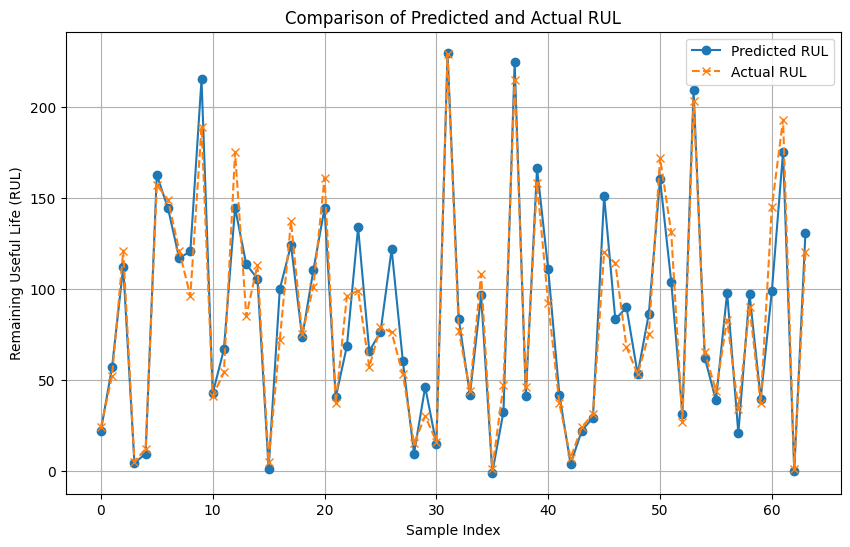

In [98]:
samples, targets = next(iter(validation_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samples, targets = samples.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    predictions = model(samples)

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

print(f'actual_predictions: {actual_predictions}')
print(f'actual_targets: {actual_targets}')

# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()

## Predict on a sample

In [99]:
samples.shape

torch.Size([64, 30, 21])

In [117]:
targets

tensor([0.0665, 0.1440, 0.3352, 0.0139, 0.0332, 0.4349, 0.4127, 0.3352, 0.2659,
        0.5235, 0.1136, 0.1496, 0.4848, 0.2355, 0.3130, 0.0139, 0.1994, 0.3795,
        0.2078, 0.2798, 0.4460, 0.1025, 0.2659, 0.2742, 0.1579, 0.2188, 0.2105,
        0.1468, 0.0416, 0.0831, 0.0443, 0.6343, 0.2133, 0.1219, 0.2992, 0.0028,
        0.1302, 0.5956, 0.1274, 0.4377, 0.2548, 0.1025, 0.0194, 0.0665, 0.0859,
        0.3324, 0.3158, 0.1884, 0.1468, 0.2078, 0.4765, 0.3629, 0.0748, 0.5623,
        0.1801, 0.1219, 0.2299, 0.0942, 0.2493, 0.1025, 0.4017, 0.5346, 0.0028,
        0.3324])

In [101]:
targets.shape

torch.Size([64])

In [118]:
idx = 0
sample = samples[idx].unsqueeze(0)
target = targets[idx].unsqueeze(0)

print(sample.shape)
print(target)

torch.Size([1, 30, 21])
tensor([0.0665])


In [ ]:
model.eval()
with torch.no_grad():
    prediction = model(sample)

sample = sample.cpu()
target = target.cpu()
prediction = prediction.cpu()

print(f'Prediction: {prediction}')
print(f'Target: {target}')

rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

prediction = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_prediction = sum(prediction)/len(prediction)
actual_target = targets.numpy() * (rul_max - rul_min) + rul_min

# print(f'Giá trị RUL thực tế {actual_target}')
print(f'Giá trị RUL thực tế {actual_target[-1]}')
print(f'Giá trị RUL dự đoán {actual_prediction}')

In [122]:
prediction

tensor([0.0609])

In [123]:
target

tensor([0.0665])